## Initialisation

In [1]:
import os

import numpy as np # type: ignore
import pandas as pd # type: ignore

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
core_used = 32
normalised = True
save_model = True
fixed_random_seed = 42  # -1 for no seed, NOT IN USE
save_figure = False
save_data = True
show_figure = False
rngs = list(range(100)) # for stable rng, for pure random, a random set can be used

In [4]:
# dynamic_data_code = 'fgfr4_ccle_dynamic_features_v2'
# drug_code = 'gdsc-1-FGFR_0939'
# match_rules_data_code = 'fgfr4_model_ccle_match_rules'
# folder_name = "FGFR4-combined-model-training"
# exp_id = "fgfr4_v4"  # experiment id, fgfr4_v1, cdk46_v1

In [5]:
dynamic_data_code = 'cdk46_ccle_dynamic_features_v3'
drug_code = 'gdsc-2-Palbociclib'
match_rules_data_code = 'cdk_model_match_rules'
folder_name = "CDK46-tree-model-refined-training"
exp_id = "cdk46_t1" # experiment id, fgfr4_v1, cdk46_v1

In [6]:
# load in dynamic features data 
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_data_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = f'ccle-{drug_code}-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

match_rules = data_link.get_data_from_code(match_rules_data_code)

Data loaded for code generic-gdsc-2-Palbociclib-LN_IC50-cdk46_ccle_dynamic_features_v3-true-Unnamed: 0 Feature Shape (584, 590) Label Shape (584,)
Data loaded for code ccle-gdsc-2-Palbociclib-LN_IC50 Feature Shape (584, 19221) Label Shape (584,)


In [7]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
all_models = ['RandomForestRegressor', 'XGBRegressor']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [9]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(584, 19221)
(584,)


In [10]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [11]:
def normalise_data(data): 
    data = (data - data.mean()) / data.std()
    return data

def pipeline_func(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first 
    # normalise X_train 
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}
    
def eval_func(X_test, y_test, pipeline_components=None, 
              normalised=False,
              save_model=False, 
              **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    returned_data = {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

def eval_func_best(X_test, y_test, pipeline_components=None, normalised=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

#### custom pipelines

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector # type: ignore

def pipeline_func_ffs(X_train, y_train, rng, model_used, k=25, normalised=False, **kwargs):
    # impute missing values by first quantile first
    # normalise X_train
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    ffs_model = get_model_from_string(model_used, **kwargs)
    sfs_forward = SequentialFeatureSelector(
        ffs_model, n_features_to_select=k, direction="forward"
    ).fit(X_train, y_train)
    # unfortunately, scikit-learn does not provide the order of the features selected
    selected_features = list(X_train.columns[sfs_forward.get_support()])
    _, scores = f_regression_select(X_train, y_train, k) # use f_regression score as a substitute, not ideal 
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(
        X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}

In [13]:
transformed_gene_list = [] 
# we deduce these from the original match rules file

gene_match_rules = match_rules.dropna(subset=['reference'])
for index, row in gene_match_rules.iterrows():
    gene = row['reference'].split(';')
    for g in gene:
        if g not in transformed_gene_list:
            transformed_gene_list.append(g)    
            
dynamic_features = list(dynamic_feature_data.columns)
transformed_dynamic_features = []
for f in dynamic_features:
    transformed_dynamic_features.append(f)
for g in transformed_gene_list:
    if g not in transformed_dynamic_features:
        transformed_dynamic_features.append(g)
        
print(f'Length of transformed gene features: {len(transformed_gene_list)}')
print(f'Length of transformed dynamic features: {len(transformed_dynamic_features)}')

Length of transformed gene features: 39
Length of transformed dynamic features: 629


## Negative Control (random data)

In [ ]:
# generate a random dataset for testing
import numpy as np

# set random seed
np.random.seed(42)

X = np.random.rand(1000, 500)
y = np.random.rand(1000)

X = pd.DataFrame(X)
y = pd.Series(y)

In [ ]:
powerkit = Powerkit(X, y)

In [ ]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func_ffs, {'model_used': model_used, 'normalised': normalised}, eval_func, {'normalised': normalised})

In [ ]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_negative.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Positive Control (make_regression data)

To ensure all models are working as intended

### Training

In [ ]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=500, noise=0.1)
# make X,y into dataframes
X = pd.DataFrame(X)
y = pd.Series(y)

In [ ]:
powerkit = Powerkit(X, y)

In [ ]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func_ffs, {'model_used': model_used, 'normalised': normalised}, eval_func, {'normalised': normalised})

In [ ]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_positive.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Dynamic Feature Only

In [ ]:
sub_exp_id = 'dynamic_features'

In [ ]:
powerkit = Powerkit(dynamic_feature_data, dynamic_label_data)

In [ ]:

for model_used in all_models:
    pipeline_args = {'model_used': model_used}
    eval_args = {'save_model': save_model, 'normalised': normalised}
    powerkit.add_condition(model_used, True, pipeline_func_ffs, pipeline_args, eval_func, eval_args)

In [ ]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_{sub_exp_id}.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Analysis

In [15]:
import pickle
experiments = ['dynamic_features']

model_used = "RandomForestRegressor"

df_list_total = []
for exp in experiments:
    df_list = []
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
    print(f'Loaded {model_used} for {exp}')
    df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)

total_df = pd.concat(df_list_total, axis=0)
# total_df

Loaded RandomForestRegressor for dynamic_features


In [16]:
# for each model, create a dataframe with the feature importance of all features 

all_new_feat_imp = []
for index, row in total_df.iterrows():
    model = row['model']
    # print(model, row['condition'], row['rng'], row['experiment'])
    importances = model.feature_importances_.tolist()
    feature_names = row['feature_importance'][0]
    # make index a repeat of index over the number of features
    feat_imp = (feature_names, importances)
    all_new_feat_imp.append(feat_imp)
    
total_df.insert(4, 'tree_feature_importance', all_new_feat_imp)
    

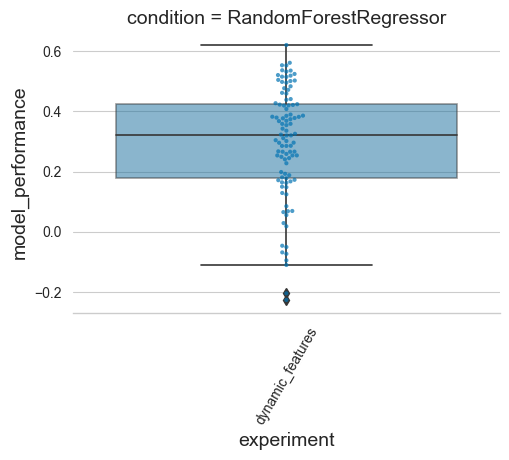

In [17]:
import seaborn as sns
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":14,"axes.labelsize":14, 'xtick.labelsize': 10, 'ytick.labelsize': 10}) 
sns.set_style("whitegrid")
sns.set_palette("colorblind")



g = sns.catplot(
    data=total_df, x="experiment", y="model_performance", col="condition",
    kind="box", height=4, aspect=1.2, sharey=True, sharex=True, col_wrap=3,
    boxprops=dict(alpha=.5),
)
g.set_xticklabels(rotation=60)
for ax in g.axes.flat:
    # ax.axhline(0, color='black', linestyle='--')
    condition_df = total_df[total_df['condition'] == ax.title.get_text().split('=')[1].strip(' ')]
    # print(ax.title.get_text().split('=')[1].strip(' '))
    sns.swarmplot(data=condition_df, x="experiment", y="model_performance", alpha=0.7, ax=ax, size=3)
    
g.despine(left=True)
plt.show()

### Feature Importance

In [46]:
powerkit = Powerkit(new_feature_data, new_label_data)
exp_condition = 'dynamic_features'
# rename the 'experiment' column to 'condition' and 'condition' to 'model_name' 
total_df['model_name'] = total_df['condition']
total_df['condition'] = total_df['experiment']
mean_contribution = powerkit.get_mean_contribution(total_df, 
                                                   exp_condition, 
                                                   'feature_importance', 
                                                   strict_mean=0.05)
mean_variation = get_variation(total_df, exp_condition, 
                               col_name='feature_importance', 
                               strict_mean=0.05,
                               use_iqr=False)

In [47]:
mean_contribution.shape

(102, 3)

In [48]:
mean_variation.shape

(102, 4)

In [49]:
# join the two dataframes
mean_df = mean_contribution.join(mean_variation, rsuffix='_variation')

In [50]:
mean_df.head(10)

,iteration_no,scores,count,variability_score,std,mean,count_variation
feature_names,,,,,,,
IRSi_tmin,55.137931,109.534113,29,0.084878,9.297084,109.534113,29
INSRpY_ttsv,46.000000,109.197610,13,0.085439,9.329734,109.197610,13
INSRpY_tmax,48.818182,108.845488,22,0.071336,7.764656,108.845488,22
IRSi_tmax,46.629630,108.774321,27,0.068140,7.411889,108.774321,27
IRS_tmin,44.933333,108.670012,15,0.072337,7.860864,108.670012,15
INSR_tmin,50.375000,108.480842,16,0.119869,13.003511,108.480842,16
INSRccIRSccPI3K_tmin,48.153846,108.431799,26,0.054337,5.891883,108.431799,26
INSR_tmax,52.181818,107.105935,22,0.063358,6.786022,107.105935,22
INSRpY_tmin,42.083333,107.035174,24,0.074281,7.950673,107.035174,24


In [51]:
import seaborn as sns
condition_df = total_df[total_df['condition'] == exp_condition]
data = condition_df['tree_feature_importance']

# extract the feature names and scores from the feature importance column
feature_names = []
scores = []

for row in data:
    feature_names.append(row[0])
    scores.append(row[1])

print(len(feature_names), len(scores))

feature_names_all = []
scores_all = []

for feature_name, score in zip(feature_names, scores):
    for feature, score in zip(feature_name, score):
        feature_names_all.append(feature)
        scores_all.append(score)

print(len(feature_names_all), len(scores_all))

# create a dataframe from the feature names and scores
df = pd.DataFrame({'feature_names': feature_names_all, 'scores': scores_all})

df.head()


100 100
2500 2500


,feature_names,scores
0,INSR_ttsv,0.167779
1,INSRpY_tmax,0.000000
2,INSRpY_tmin,0.002184
3,S6KpT389_tmin,0.000000
4,PI3K_tmax,0.000000


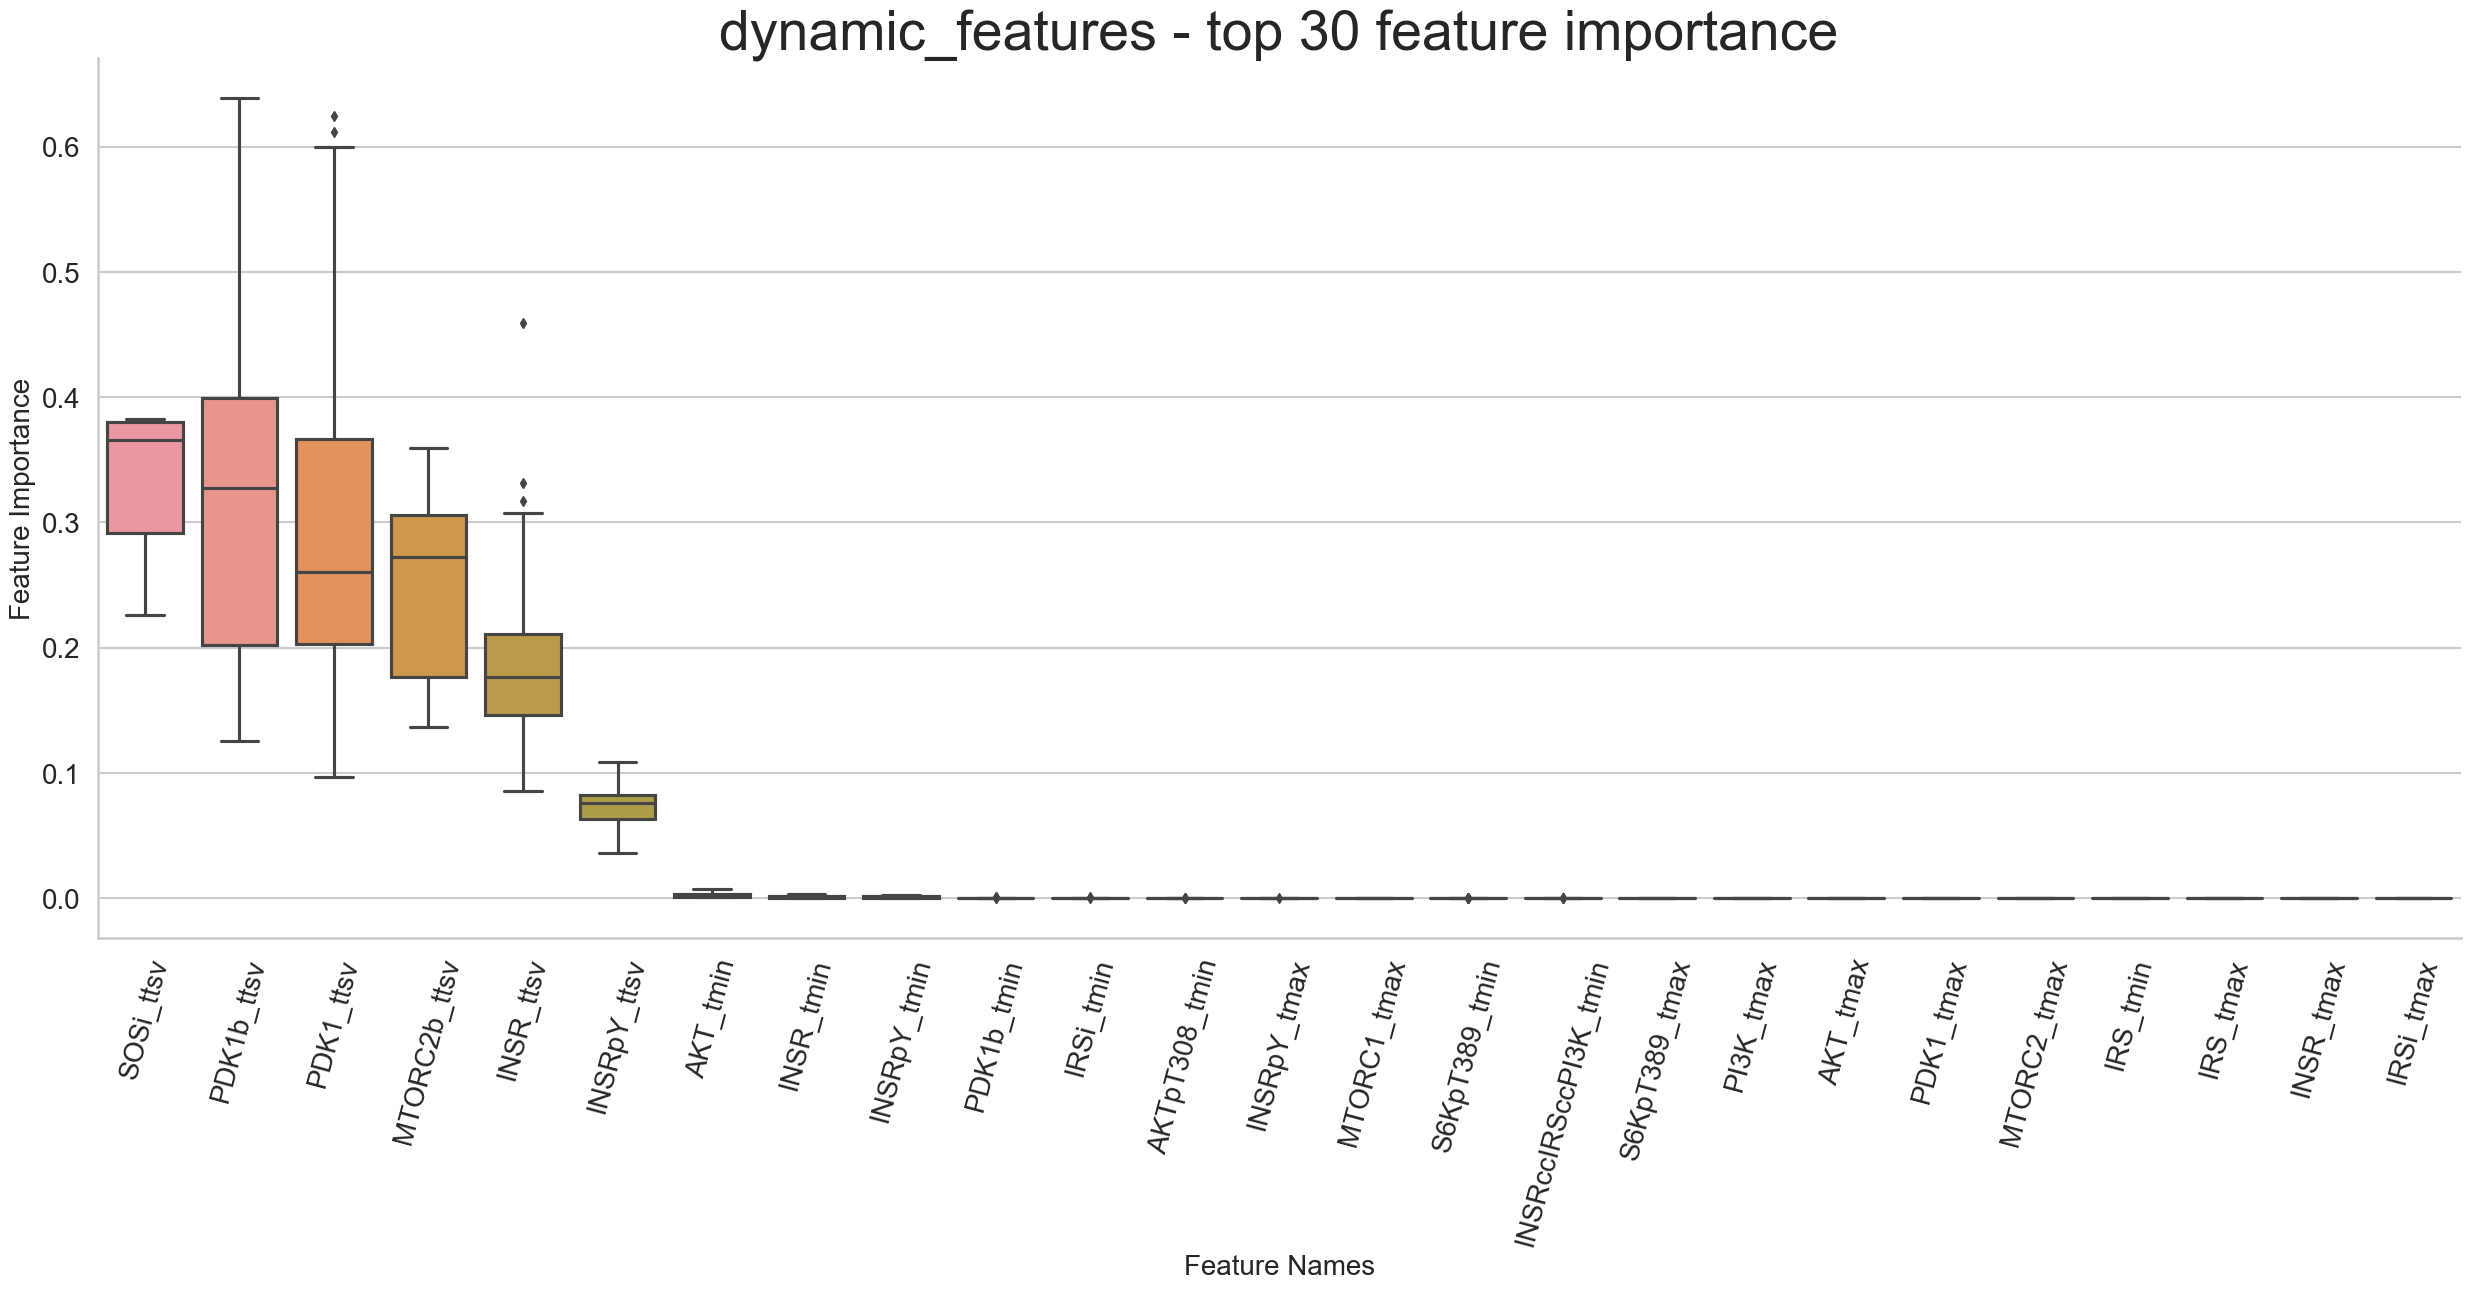

In [52]:
features_to_include = mean_df.index[:25]

# filter the dataframe by the features to include
filtered_df = df[df['feature_names'].isin(features_to_include)]

plot_order = filtered_df.groupby('feature_names').mean().sort_values('scores', ascending=False).index

sns.set_context('talk')

# plot the boxplot
sns.catplot(x='feature_names', y='scores', data=filtered_df, kind='box', height=10, aspect=2.5, order=plot_order)

# enlarge the x axis labels and y axis labels
plt.xlabel('Feature Names', fontsize=20)
plt.ylabel('Feature Importance', fontsize=20)
plt.title(f'{exp_condition} - top 30 feature importance', fontsize=40)
plt.xticks(rotation=75, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

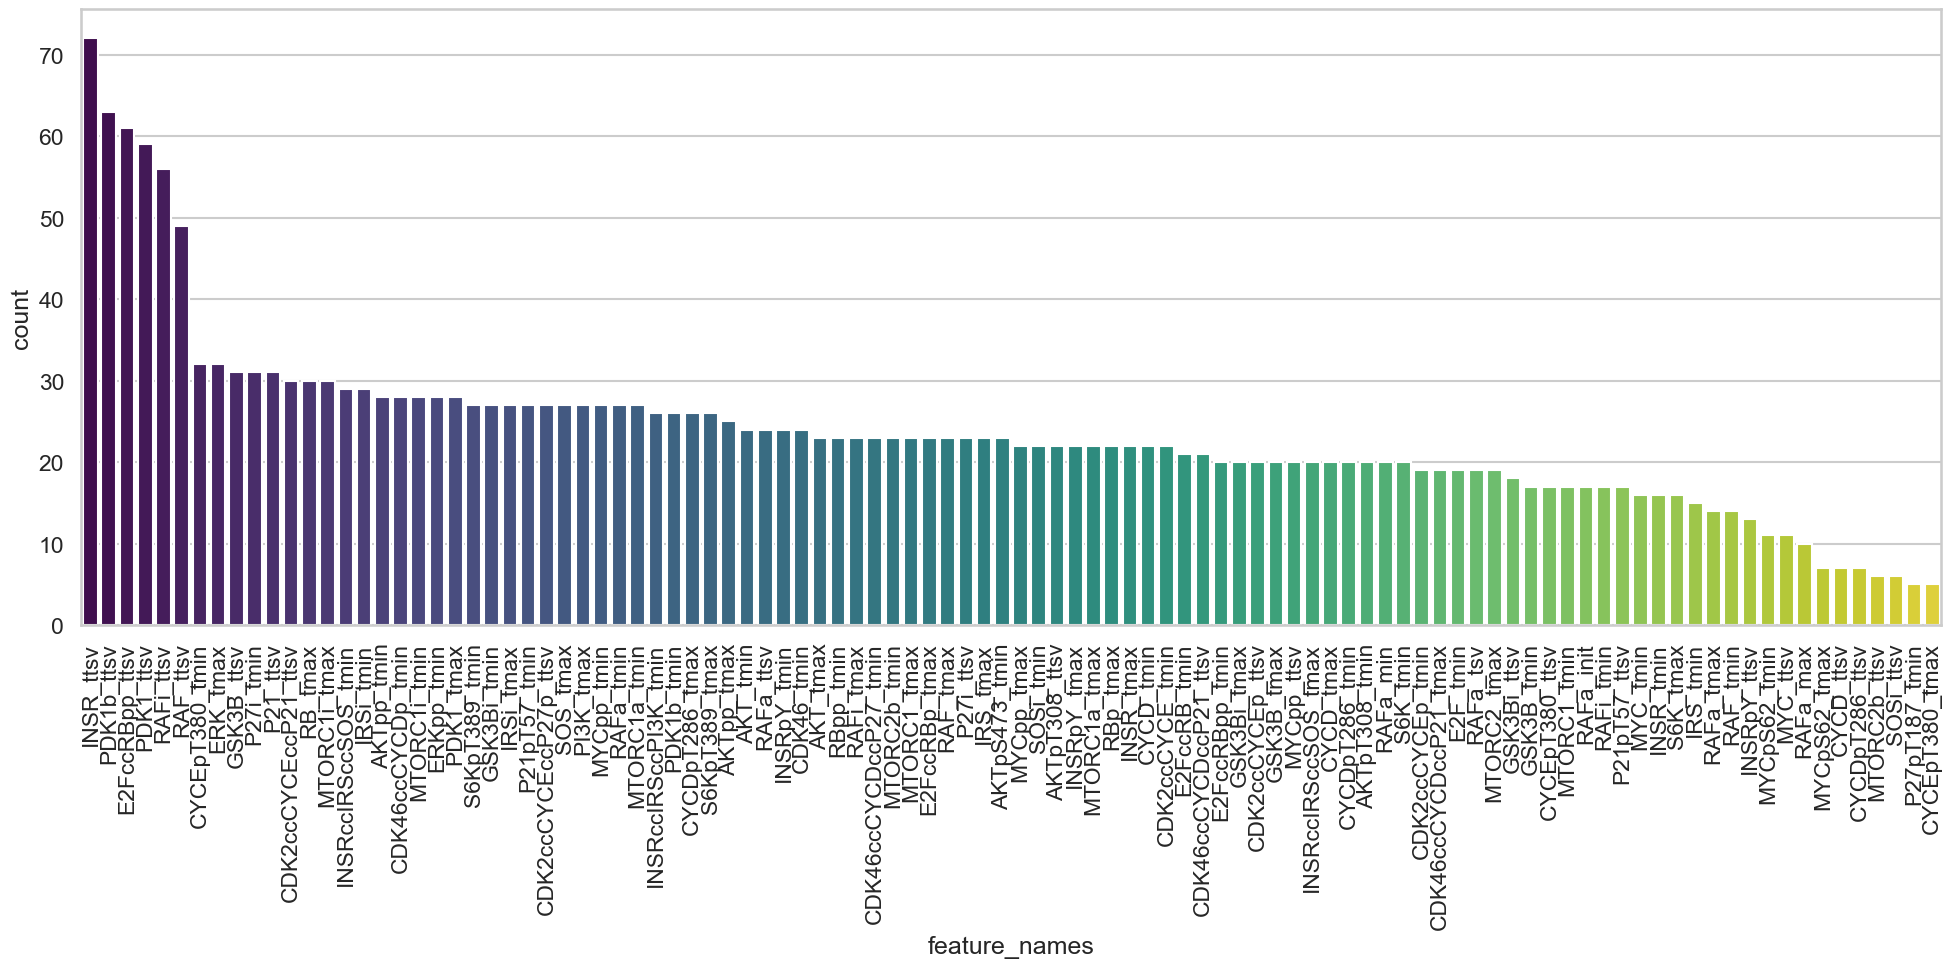

In [59]:
# sort features by count and plot using mean_df 

mean_df = mean_df.sort_values('count', ascending=False)

# plot count values as a bar plot 

sns.set_context('talk')
plt.figure(figsize=(24, 8))
sns.barplot(x=mean_df.index, y=mean_df['count'], palette='viridis')
plt.xticks(rotation=90)
plt.show()